## From chatGPT (experimental)

### 💡 **Recommended Approach** (Latent Gaussian Graphical Model):

To reliably induce correlation across edges:

- **Step 1**: Sample a latent Gaussian vector for each gene with a structured covariance.
- **Step 2**: Introduce correlation explicitly through the graph structure.
- **Step 3**: Convert latent Gaussian vectors to integer counts via a suitable link function (Poisson).

---

## **Minimal Implementation (no spatial distances):**

Here's how to achieve this step-by-step clearly:

### **1. Define Covariance using Graph Structure**:

Given adjacency `G` (edges), we construct covariance as:


$$C = (\alpha I + \beta G)^{-1}$$

where:

- \(G\) is your adjacency matrix (binary, symmetric),
- \(\alpha\) (self-weight) ensures positive definiteness (e.g. α = degree + small constant),
- \(\beta\) controls edge-based correlation strength.

### **2. Generate Two Latent Gaussian Vectors**:

We want counts for two genes, say ligand (`L`) and receptor (`R`).  
To induce correlation specifically over edges, we sample latent Gaussian vectors jointly with covariance:

$$
\text{Cov}\bigl([L, R]\bigr) = 
\begin{pmatrix}
C & \rho C \\
\rho C & C
\end{pmatrix}
$$

where \(\rho\) controls desired correlation.

### **3. Convert Latent Variables to Counts**:

Apply exponential link to Poisson rates:

$$
\lambda_L = \exp(\mu_L + Z_L), \quad \lambda_R = \exp(\mu_R + Z_R)
$$

and then sample:

- \( L_i \sim \text{Poisson}(\lambda_{L,i}) \)
- \( R_i \sim \text{Poisson}(\lambda_{R,i}) \)

---

In [6]:
import numpy as np
from scipy.stats import multivariate_normal, poisson
from scipy.sparse import csgraph
from numpy.linalg import inv
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [3]:
def simulate_counts_graph_corr(G_adj, desired_corr=0.8, mu_L=1.0, mu_R=1.0):
    """
    Simulate counts for two genes with correlation across edges.

    Parameters:
        G_adj (np.ndarray): adjacency matrix (binary, symmetric)
        desired_corr (float): target correlation between genes across edges
        mu_L, mu_R (float): baseline log-expression for L and R genes

    Returns:
        L_counts, R_counts (np.ndarray): integer counts per node
    """
    n = G_adj.shape[0]

    # Ensure G_adj symmetric and binary
    G_adj = (G_adj > 0).astype(float)
    np.fill_diagonal(G_adj, 0)

    # Degree matrix and small epsilon to ensure positive definiteness
    degrees = G_adj.sum(axis=1)
    alpha = np.diag(degrees + 0.1)
    beta = 0.9  # strength of correlation between neighbors (tunable)

    # Precision and covariance matrix (graph-structured covariance)
    precision_single = alpha - beta * G_adj
    covariance_single = inv(precision_single)

    # Joint covariance matrix (2 genes: L and R)
    covariance_joint = np.block([
        [covariance_single, desired_corr * covariance_single],
        [desired_corr * covariance_single, covariance_single]
    ])

    # Sample latent Gaussian vectors
    latent = multivariate_normal.rvs(
        mean=np.zeros(2*n), cov=covariance_joint
    )
    Z_L, Z_R = latent[:n], latent[n:]

    # Convert latent Gaussian to Poisson rates
    lambda_L = np.exp(mu_L + Z_L)
    lambda_R = np.exp(mu_R + Z_R)

    # Sample counts
    L_counts = poisson.rvs(lambda_L)
    R_counts = poisson.rvs(lambda_R)

    return L_counts, R_counts

In [7]:
n = 100  # you can change this
coords = np.random.uniform(low=0, high=10, size=(n, 2))
loc_df = pd.DataFrame(
    coords, 
    columns = ['x', 'y']
)

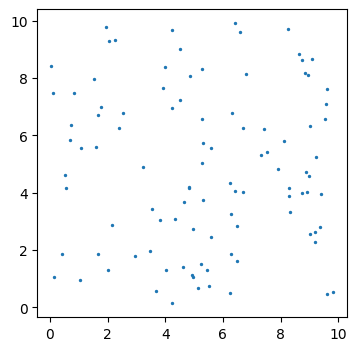

In [8]:
plt.figure(figsize=(4,4))
plt.scatter(loc_df.x, loc_df.y, s=2)
plt.show()

In [9]:
import numpy as np
from scipy.spatial import KDTree, distance_matrix
from scipy.sparse import lil_matrix
from kneed import KneeLocator  # install with: pip install kneed

def find_cutoff_radius(coords, plot=False):
    """
    Find a good cutoff radius for d-ball neighbors using a knee-finding algorithm.
    
    Parameters:
        coords (np.ndarray): N x 2 coordinate array
        plot (bool): If True, plot the sorted distances and detected knee point

    Returns:
        float: estimated cutoff radius
    """
    n = coords.shape[0]
    
    # Compute upper-triangle pairwise distances
    dists = distance_matrix(coords, coords)
    dists = dists[np.triu_indices(n, k=1)]
    sorted_dists = np.sort(dists)

    # Knee detection
    x = np.arange(len(sorted_dists))
    kneedle = KneeLocator(x, sorted_dists, curve="concave", direction="increasing")
    
    if kneedle.knee is not None:
        cutoff_radius = sorted_dists[kneedle.knee]
    else:
        cutoff_radius = np.percentile(sorted_dists, 5)

    # Optional plotting
    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(sorted_dists, label='Sorted distances')
        if kneedle.knee is not None:
            plt.axvline(x=kneedle.knee, color='red', linestyle='--', label=f'Knee at {cutoff_radius:.2f}')
        plt.xlabel("Index")
        plt.ylabel("Distance")
        plt.title("Knee Detection for Cutoff Radius")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return cutoff_radius


def spatial_neighbors(coords, n_rings=1, coord_type='grid', radius=None):
    """
    Compute spatial neighbors using either grid or generic coordinates.

    Parameters:
        coords (np.ndarray): N x 2 array of 2D spatial coordinates
        n_rings (int): Number of rings (for 'grid') or ignored if 'generic'
        coord_type (str): 'grid' or 'generic'
        radius (float): radius for ball query (only for generic)

    Returns:
        scipy.sparse.csr_matrix: Sparse matrix of Euclidean distances
    """
    n = coords.shape[0]
    mat = lil_matrix((n, n))
    
    kdt = KDTree(coords)
    
    if coord_type == 'grid':
        # Grid layout: approximate by kNN
        dists, indices = kdt.query(coords, k=(8 * n_rings + 1))
        for i in range(n):
            for j, dist in zip(indices[i], dists[i]):
                if i != j:
                    mat[i, j] = dist

    elif coord_type == 'generic':
        if radius is None:
            radius = find_cutoff_radius(coords)
        
        neighbors = kdt.query_ball_point(coords, r=radius)
        for i, nbrs in enumerate(neighbors):
            for j in nbrs:
                if i != j:
                    dist = np.linalg.norm(coords[i] - coords[j])
                    mat[i, j] = dist

    return mat.tocsr()


def get_edge_indices(mat,self_loops=False):
    """
    Extract unique directed edge indices from sparse graph.

    Parameters:
        mat (scipy.sparse matrix): adjacency matrix

    Returns:
        edges (np.ndarray): shape (n_edges, 2), where each row is (i, j)
    """
    G = mat.tocoo()
    if self_loops:
        mask = G.row <= G.col
    else:
        mask = G.row < G.col

    edges = np.vstack((G.row[mask], G.col[mask])).T
    return edges

In [10]:
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

def plot_spatial_graph(coords, mat):
    """
    Plot spatial graph edges and node positions.

    Parameters:
        coords (np.ndarray): N x 2 array of coordinates
        mat (scipy.sparse matrix): Sparse matrix of distances (edges)
    """
    plt.figure(figsize=(4, 4))

    # Plot edges from sparse matrix
    mat_coo = mat.tocoo()
    for i, j in zip(mat_coo.row, mat_coo.col):
        if i < j:  # plot each edge once
            x_vals = [coords[i, 0], coords[j, 0]]
            y_vals = [coords[i, 1], coords[j, 1]]
            plt.plot(x_vals, y_vals, color='lightgray', linewidth=0.5)

    # Plot points
    plt.scatter(coords[:, 0], coords[:, 1], s=2, color='black')

    plt.axis('equal')
    plt.title("Spatial Graph")
    plt.tight_layout()
    plt.show()


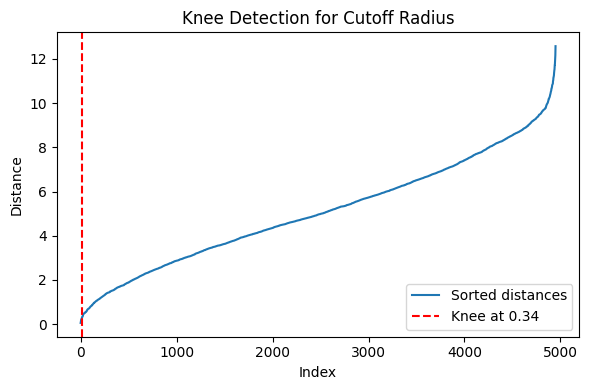

In [11]:
cutoff_dist = find_cutoff_radius(coords, plot=True)

In [12]:
dist_mat = spatial_neighbors(loc_df.values, coord_type='generic', radius=1.5)

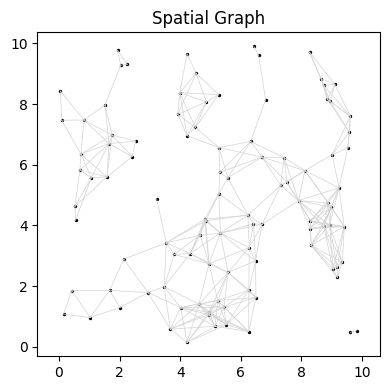

In [13]:
plot_spatial_graph(coords, dist_mat)

In [14]:
G_rand = np.triu(dist_mat, 1)
G_adj = G_rand + G_rand.T

L_counts, R_counts = simulate_counts_graph_corr(G_adj, desired_corr=0.8)

# Check actual correlation across edges
edges = np.array(np.where(np.triu(G_adj, 1))).T
L_edge = L_counts[edges[:, 0]]
R_edge = R_counts[edges[:, 1]]
print("Correlation across edges:", np.corrcoef(L_edge, R_edge)[0, 1])

TypeError: tri() missing 1 required positional argument: 'N'